In [1]:
%pip install rosbags pandas
# Import required libraries
import rosbags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.typesys import Stores, get_typestore, get_types_from_msg



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Path to the ROS1 bag file
#bag_path = Path('../../assets/extintor_bag')
bag_path = Path('./rosbag_martelo/martelo')
output_dir = Path(f'../../outputs/spot_images/{TEXT_LABEL}')


In [26]:
with AnyReader([bag_path]) as reader:
    topics = reader.topics

print("Available topics:")
for topic in topics:
    total_messages = topics[topic].msgcount
    total_time = 5 * 60 # seconds
    print(f" - {topic} ({topics[topic].msgtype}) (total: {total_messages/total_time})")


Available topics:
 - /clicked_point (geometry_msgs/msg/PointStamped) (total: 0.0)
 - /events/write_split (rosbag2_interfaces/msg/WriteSplitEvent) (total: 0.0)
 - /goal_pose (geometry_msgs/msg/PoseStamped) (total: 0.0)
 - /initialpose (geometry_msgs/msg/PoseWithCovarianceStamped) (total: 0.0)
 - /parameter_events (rcl_interfaces/msg/ParameterEvent) (total: 0.0)
 - /rosout (rcl_interfaces/msg/Log) (total: 0.04666666666666667)
 - /spot/camera/frontleft/camera_info (sensor_msgs/msg/CameraInfo) (total: 0.8733333333333333)
 - /spot/camera/frontleft/image (sensor_msgs/msg/Image) (total: 0.87)
 - /spot/camera/frontright/camera_info (sensor_msgs/msg/CameraInfo) (total: 0.8733333333333333)
 - /spot/camera/frontright/image (sensor_msgs/msg/Image) (total: 0.8733333333333333)
 - /spot/depth/frontleft/camera_info (sensor_msgs/msg/CameraInfo) (total: 0.8733333333333333)
 - /spot/depth/frontleft/image (sensor_msgs/msg/Image) (total: 0.8733333333333333)
 - /spot/depth/frontright/camera_info (sensor_msg

In [32]:
from tqdm.notebook import tqdm

# save the images from  /spot/depth/frontright/image  in the files ../../assets/spot_front_right_images
# Define the output directory and create it if it doesn't exist
output_dir = Path('../../outputs/spot')
output_dir.mkdir(parents=True, exist_ok=True)

# Open the bag file with AnyReader
with AnyReader([bag_path]) as reader:
    # Filter connections for the desired topic
    topic_name = '/spot/depth_registered/frontright/image'
    connections = [x for x in reader.connections if x.topic == topic_name]
    
    # Get the total number of messages for the progress bar
    total_messages = sum(x.msgcount for x in connections)
    
    image_count = 0
    # Iterate over messages in the filtered connections with a progress bar
    for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections), total=total_messages, desc=f"Extracting images from {topic_name}"):
        # Deserialize the message
        msg = reader.deserialize(rawdata, connection.msgtype)
        assert msg.encoding == "16UC1"
        image_array = np.frombuffer(msg.data, dtype="<u2").reshape(msg.height, msg.width).copy()
        image_array = image_array.astype('<u2')#.byteswap(inplace=True)

        # Define the filename for the image
        filename = output_dir / f'{image_count:04d}_frontright_depth.png'
        
        image_array = np.rot90(image_array, k=-1) #/ 1000

        # Save the image using matplotlib
        plt.imsave(filename, image_array, cmap='gray')
        image_count += 1
        break
print(f"Saved {image_count} images to {output_dir}")

Extracting images from /spot/depth_registered/frontright/image:   0%|          | 0/235 [00:00<?, ?it/s]

Saved 1 images to ../../outputs/spot


(640, 480)

(424, 240)

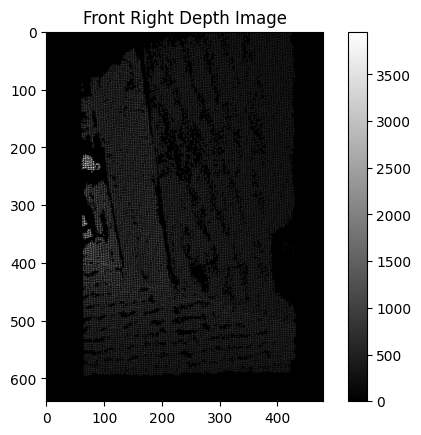

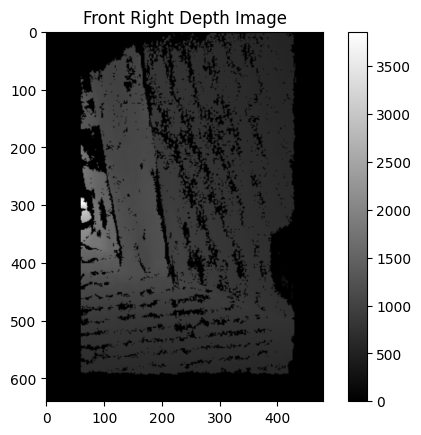

In [57]:
import torch.nn as nn
import cv2

display(image_array.shape)
display(image_array2.shape)
# Resize 424 to 597
# Resize 240 to 372
image_resized = cv2.resize(image_array2[30:, :], (372, 597, )) 
img2 =np.pad(image_resized, ((0, 640-597), (60, 48)), mode="constant", constant_values=1)

plt.imshow(image_array, cmap='gray')
plt.title('Front Right Depth Image')
plt.colorbar()
plt.show()

plt.imshow(img2, cmap='gray')
plt.title('Front Right Depth Image')
plt.colorbar()
plt.show()

In [47]:
# Get the index of the first non-zero value for each row (along the x-axis)
first_non_zero_x = np.argmax(image_array > 0, axis=0)

# To handle rows that are all zeros (where argmax would return 0), 
# we can create a mask to identify them.
all_zero_rows = np.all(image_array == 0, axis=0)

# Where the row was all zeros, we can set the index to a special value like -1
first_non_zero_x[all_zero_rows] = -1

# print the rows with all zeros:
print("Rows with all zeros:")
print(np.where(all_zero_rows)[0])
print("Index of the first non-zero value on the X-axis for each row:")
print(first_non_zero_x)

Rows with all zeros:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479]
Index of the first non-zero value on the X-axis for each row:
[ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  92  90 116 101 160 116 114 154 121 114 143
 114 114 136 112  82 126  81  83 120  80  80 111  82  80 104  80  80  94
  76 140  98  82 131  79  81 122  78  72 114  75  74 105  72  69  97  69
  67  89  62  61  80  60  58  70  5

In [6]:
from tqdm.notebook import tqdm
from pathlib import Path

images: dict[str, list[tuple[float, np.ndarray]]] = {"frontright": [], "frontleft": []}

# Open the bag file with AnyReader
with AnyReader([bag_path]) as reader:
    # Filter connections for the desired topic
    for side in ["frontright", 'frontleft']:
        topic_name = f'/spot/camera/{side}/image'
        connections = [x for x in reader.connections if x.topic == topic_name]
        output_dir = Path('../../outputs/spot')
        output_dir.mkdir(parents=True, exist_ok=True)
        # Get the total number of messages for the progress bar
        total_messages = sum(x.msgcount for x in connections)
        
        image_count = 0
        # Iterate over messages in the filtered connections with a progress bar
        for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections), total=total_messages, desc=f"Extracting images from {topic_name}"):
            # Deserialize the message
            msg = reader.deserialize(rawdata, connection.msgtype)

            # Convert image data to a numpy array and reshape it
            assert msg.encoding.lower() == "bgr8", f"Unexpected encoding: {msg.encoding}"
            image_array = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, 3)

            # Define the filename for the image
            filename = output_dir / f'{image_count:04d}_{side}_image.png'

            # Reshape from bgr to rgb
            image_array = image_array[..., ::-1]

            # Rotate -90º
            image_array = np.rot90(image_array, k=-1)

            # Save the image using matplotlib
            plt.imsave(filename, image_array)
            images[side].append((msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9, image_array))
            image_count += 1

        print(f"Saved {image_count} images to {output_dir}")

Extracting images from /spot/camera/frontright/image:   0%|          | 0/1168 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [51]:
# Match the image with closes timestamp for the one with less images
smallest_images_idx = "frontleft" if len(images["frontleft"]) < len(images["frontright"]) else "frontright"
biggest_images_idx = "frontright" if len(images["frontleft"]) < len(images["frontright"]) else "frontleft"

smallest_images = images[smallest_images_idx]
biggest_images = images[biggest_images_idx]

# Match from the smallest for each biggest
matched_images: list[dict[str, np.ndarray]] = []

for small in smallest_images:
    # Find the closest big image
    closest_big = min(biggest_images, key=lambda x: abs(x[0] - small[0]))

    matched_images.append({
        smallest_images_idx: small[1],
        biggest_images_idx: closest_big[1],
        "small_timestamp": small[0],
        "big_timestamp": closest_big[0]
    })

print(len(matched_images))


1166


In [52]:
from PIL import Image
import torch
device = "cuda"

from transformers import Owlv2Processor, Owlv2ForObjectDetection
from transformers.models.owlv2.processing_owlv2 import Owlv2ProcessorKwargs
from isaaclab_datasets_generation.custom_vla.student_teacher_customv2 import (
    StudentTeacherCustomv2,
)

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to(device)

In [ ]:
import os
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches

TEXT_LABEL = "monitor"
# Delete before re-creating
shutil.rmtree(output_dir, ignore_errors=True)
os.makedirs(output_dir, exist_ok=True)

# Iterate over all demonstrations in the dataset

for idx, entry in tqdm(enumerate(matched_images), desc="Processing Images", total=len(matched_images)):

    if idx % 5 != 0:
        # To many frames 
        continue 

    right_images = entry["frontright"]
    left_images = entry["frontleft"]

    # Iterate over all frames in the current demonstration
    # Convert the image to a PIL Image
    r_img = Image.fromarray(np.rot90(right_images, k=-1))
    l_img = Image.fromarray(np.rot90(left_images, k=-1))

    # Prepare inputs for the object detection model
    inputs = processor(images=l_img, text=[TEXT_LABEL], return_tensors="pt").to(device)
    inputs2 = processor(images=r_img, text=[TEXT_LABEL], return_tensors="pt").to(device)

    with torch.no_grad():
        outputs_left = model(**inputs)
        outputs_right = model(**inputs2)

    # Post-process the object detection results
    target_sizes = torch.tensor([(l_img.height, l_img.width)])
    l_result = processor.post_process_grounded_object_detection(
        outputs=outputs_left, target_sizes=target_sizes, threshold=0.1, text_labels=[TEXT_LABEL]
    )
    r_result = processor.post_process_grounded_object_detection(
        outputs=outputs_right, target_sizes=target_sizes, threshold=0.1, text_labels=[TEXT_LABEL]
    )

    # Create figure and axes for plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 9))
    ax[0].imshow(r_img)
    ax[1].imshow(l_img)

    # Plot the bounding boxes on the images
    for n, result in enumerate([r_result[0], l_result[0]]):
        for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            if score < 0.2:
                continue
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax[n].add_patch(rect)
            ax[n].text(xmin, ymin, f'{label}: {score:.2f}', bbox=dict(facecolor='red', alpha=0.5))

    # Set titles and layout
    #ax[0].set_title(f"Expected Action: {action[0]}")
    #ax[1].set_title(f"Estimated Action: {action_estimated}")

    ax[0].axis('off')
    ax[1].axis('off')
    #plt.suptitle(f"Object: {object_names} | Success: {had_success[0]}, Truncated: {had_truncation[0]}")
    plt.tight_layout()
    
    # Save the figure instead of showing it
    save_path = os.path.join(output_dir, f"frame_{idx:04d}.png")
    plt.suptitle(f"{TEXT_LABEL} - Index {idx}")
    plt.savefig(save_path)
    plt.close(fig) # Close the figure to free up memory

print(f"Saved all frames to {output_dir}")

Processing Images:   0%|          | 0/1166 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 594.00 MiB. GPU 0 has a total capacity of 44.40 GiB of which 168.62 MiB is free. Process 434721 has 462.70 MiB memory in use. Process 849990 has 2.96 GiB memory in use. Process 924993 has 37.82 GiB memory in use. Including non-PyTorch memory, this process has 2.97 GiB memory in use. Of the allocated memory 1.83 GiB is allocated by PyTorch, and 669.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)